# STAT 4830 Lecture 0: Building a Spam Filter with PyTorch

Our spam filter uses these key ingredients:

1. A collection of emails labeled as spam or legitimate
2. Features that capture telltale signs of spam
3. A model that learns to spot these patterns
4. Training that improves the model's accuracy

Let's start by preparing our data and model:

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

sns.set_style("whitegrid")

# Sample emails for training
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List
import seaborn as sns
sns.set_style("whitegrid")

# spam emails 
spam_emails = [
    "URGENT! You've won $1,000,000!!! Claim your prize NOW at www.not-a-scam.com",
    "Buy cheap watches! Limited time offer!!! Click here: www.watches4u.com!!!",
    "Make $$$ from home!! Secret method revealed at www.get-rich-quick.com!!!",
    "Congratulations! You're our lucky winner!!! Claim NOW at www.lucky-prizes.com",
    "AMAZING investment opportunity!!! 1000% returns guaranteed! www.invest-here.com",
    "Double your money in 24 hours! Expert system at www.trading-genius.com!!!",
    "Exclusive VIP membership waiting! Click now: www.elite-status.com",
    "Your account needs verification! Update details: www.secure-bank-verify.com",
    "Work from home! Earn $500/day! Training at www.easy-income.com",
    "LAST CHANCE! 90% OFF Designer Items at www.luxury-deals.com!!!",
    "You're pre-approved! Claim loan NOW at www.quick-cash-loans.com",
    "Lose 20 pounds in 1 week! Secret formula: www.miracle-weight-loss.com",
    "FREE iPhone 15! You're our chosen winner: www.phone-giveaway.com",
    "Unlock your fortune! Ancient wisdom at www.wealth-secrets.com",
    "Time-limited offer! Digital coins at 50% OFF: www.crypto-deals.com"
]

# legitimate emails 
legitimate_emails = [
    # Previous examples
    "Team meeting at 2pm tomorrow. Please review the attached agenda.",
    "Hi, can you send me the Q3 sales report when you get a chance?",
    "Reminder: Performance reviews due by Friday. Submit via HR portal.",
    "Lunch next week? I'm free Tuesday or Wednesday.",
    "Project update: Phase 1 complete. Starting Phase 2 tomorrow.",
    "The budget spreadsheet has been updated with Q4 projections.",
    "Could you review the client proposal before Thursday's meeting?",
    "Building maintenance: WiFi upgrade scheduled for this weekend.",
    "Thanks for your feedback on the design mockups. Revisions attached.",
    "Your vacation request for Dec 15-20 has been approved.",
    "Please complete the annual compliance training by month-end.",
    "New parking policy effective next month. Details in handbook.",
    "Great presentation yesterday! The client was impressed.",
    "Reminder: Office closing early (3pm) for holiday party.",
    "Your requested software license has been activated."
]

# Not going to train on these 
## test spam emails 
test_spam = [
    "FREE MONEY!!! Click now www.free-cash.com!!!",
    "You're selected!!! Claim prize at www.winner-today.com",
    "URGENT: Account suspended! Verify now: www.account-verify.com!!!",
    "Win a dream vacation! Enter here: www.luxury-trips.com",
    "Special VIP access! Limited spots at www.exclusive-club.com"
]

## test legitimate emails 
test_legitimate = [
    # Previous examples
    "Updated meeting schedule for next week attached.",
    "Can we sync up about the client presentation?",
    "Don't forget about tomorrow's deadline.",
    "The quarterly report is ready for your review.",
    "Please submit your expenses by end of month."
]



The model needs numbers, not text. We extract five key features from each email:


In [11]:
def extract_features(email: str) -> Dict[str, float]:
    """Convert email text into numeric features."""
    return {
        'exclamation_count': email.count('!'),
        'urgent_words': len(set(['urgent', 'buy', 'money', 'won', 'free']) & 
                           set(email.lower().split())),
        'suspicious_links': len([w for w in email.split() if 'www' in w]),
        'caps_ratio': sum(1 for c in email if c.isupper()) / len(email),
        'length': len(email) / 500  # Normalized length
    }

def create_feature_matrix(emails: List[str]) -> torch.Tensor:
    """Convert email list into a feature matrix."""
    features = [list(extract_features(email).values()) for email in emails]
    return torch.tensor(features, dtype=torch.float32)

def sigmoid(x: torch.Tensor) -> torch.Tensor:
    """Transform scores into probabilities between 0 and 1."""
    return 1 / (1 + torch.exp(-x))

Now let's train the model to distinguish spam from legitimate emails:


In [12]:
# Prepare data
X_train = create_feature_matrix(spam_emails + legitimate_emails)
y_train = torch.tensor([1]*len(spam_emails) + [0]*len(legitimate_emails), dtype=torch.float32)

X_test = create_feature_matrix(test_spam + test_legitimate)
y_test = torch.tensor([1]*len(test_spam) + [0]*len(test_legitimate), dtype=torch.float32)

# Initialize model and optimizer
# set the seed for reproducibility
torch.manual_seed(5)

# initialize the weights
weights = torch.randn(5, requires_grad=True)
optimizer = torch.optim.SGD([weights], lr=0.1)

# Training loop
n_steps = 200 # number of steps to train for    
losses = []
test_accuracies = []

for step in range(n_steps):
    # Make predictions
    scores = X_train @ weights
    predictions = sigmoid(scores)
    
    # Calculate cross-entropy loss
    loss = -torch.mean(y_train * torch.log(predictions) + 
                      (1 - y_train) * torch.log(1 - predictions))
    
    # Update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Track progress
    losses.append(loss.item())
    with torch.no_grad():
        test_preds = sigmoid(X_test @ weights)
        test_acc = torch.mean(((test_preds > 0.5) == y_test).float()) # decision threshold is 0.5
        test_accuracies.append(test_acc.item())

Let's examine how well our model learned:

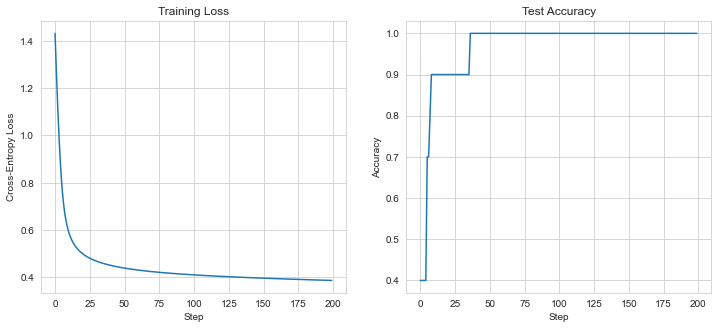

In [13]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Cross-Entropy Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.show()

The loss curve tracks how well our model classifies emails during training. The loss curve descends gradually throughout the training before plateauing. This measure how well the model is doing on the training data. 

On the other hand, the test accuracy measures something more important: how well the model spots spam in new, unseen emails. We see that the test accuracy of the model jumps multiple times until it reaches 100% accuracy.

Let's see how well this trained model performs on new emails:

In [14]:
# Evaluate on test set
with torch.no_grad():
    test_preds = sigmoid(X_test @ weights)
    print("\nTest Set Predictions:")
    for i, (pred, label) in enumerate(zip(test_preds, y_test)):
        email = test_spam[i] if i < len(test_spam) else test_legitimate[i - len(test_spam)]
        print(f"\nEmail: {email[:50]}...")
        print(f"True label: {'Spam' if label == 1 else 'Not Spam'}")
        print(f"Predicted probability of spam: {pred:.3f}")
        print(f"Prediction: {'Spam' if pred > 0.5 else 'Not Spam'}")


Test Set Predictions:

Email: FREE MONEY!!! Click now www.free-cash.com!!!...
True label: Spam
Predicted probability of spam: 1.000
Prediction: Spam

Email: You're selected!!! Claim prize at www.winner-today...
True label: Spam
Predicted probability of spam: 0.990
Prediction: Spam

Email: URGENT: Account suspended! Verify now: www.account...
True label: Spam
Predicted probability of spam: 0.997
Prediction: Spam

Email: Win a dream vacation! Enter here: www.luxury-trips...
True label: Spam
Predicted probability of spam: 0.887
Prediction: Spam

Email: Special VIP access! Limited spots at www.exclusive...
True label: Spam
Predicted probability of spam: 0.889
Prediction: Spam

Email: Updated meeting schedule for next week attached....
True label: Not Spam
Predicted probability of spam: 0.488
Prediction: Not Spam

Email: Can we sync up about the client presentation?...
True label: Not Spam
Predicted probability of spam: 0.489
Prediction: Not Spam

Email: Don't forget about tomorrow's deadl

The model assigns high spam probabilities (0.99-1.0) to emails containing "FREE MONEY" and "URGENT" with suspicious links. Vacation and VIP offers receive moderately high probabilities (0.85). Business emails about meetings and deadlines get probabilities just under 0.5 (0.48-0.49), marking them as non-spam. The model makes correct predictions across all test cases, showing it can distinguish spam characteristics while respecting legitimate business communication.

This simple model demonstrates the core principles of machine learning: extract meaningful features, train on labeled examples, and evaluate on unseen data. More sophisticated spam filters might use additional features or advanced architectures, but they follow these same fundamental steps.